##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial contains an introduction to word embeddings. You will train your own word embeddings using a simple Keras model for a sentiment classification task, and then visualize them in the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below). 

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, you will look at three strategies for doing so.

### One-hot encodings

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, you could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [1]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from datetime import datetime
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Download the IMDb Dataset
You will use the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) through the tutorial. You will train a sentiment classifier model on this dataset and in the process learn embeddings from scratch. To read more about loading a dataset from scratch, see the [Loading text tutorial](../load_data/text.ipynb).  

Download the dataset using Keras file utility and take a look at the directories.

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84131840/84125825 [==============================] - 39s 0us/step


['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

Take a look at the `train/` directory. It has `pos` and `neg` folders with movie reviews labelled as positive and negative respectively. You will use reviews from `pos` and `neg` folders to train a binary classification model.

In [3]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

The `train` directory also has additional folders which should be removed before creating training dataset.

In [4]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, create a `tf.data.Dataset` using `tf.keras.preprocessing.text_dataset_from_directory`. You can read more about using this utility in this [text classification tutorial](https://www.tensorflow.org/tutorials/keras/text_classification). 

Use the `train` directory to create both train and validation datasets with a split of 20% for validation.

In [5]:
batch_size = 1024
seed = 123
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, 
    subset='training', seed=seed)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, 
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Take a look at a few movie reviews and their labels `(1: positive, 0: negative)` from the train dataset.


In [43]:
for text_batch, label_batch in val_ds.take(5):
    print(39*'===')
    for i in range(5):
        print('label:', label_batch[i].numpy(), 'text:', text_batch.numpy()[i])


label: 0 text: b"Geordies...salt of the earth characters...bricklayers...beer...Geordies...happy go lucky...adventures working abroad...salt of the earth characters...warm wonderful people...Tyne Bridge (tear in the eye)...brown ale...salt of the earth characters...cute little Red Indians children in Newcastle United tops...emetic...Geordies...salt of the earth characters...<br /><br />etc etc etc....<br /><br />Please. This is so poor. And you should know better Timothy Spall. They can't have paid you that much.<br /><br />As for Jimmy Nail. Well the kindest thing that can be said is that he is every bit as good an 'actor' as he is a singer and writer. Come on Jimmy, the joke's over. 'Crocodile Shoes' and 'Spender' were very funny, unfortunately I don't think they were supposed to be. With 'Auf Wiedersehen Pet' the opposite applies."
label: 0 text: b"My girlfriend picked this one; as a southern born and raised African American I found this movie's plot and premise totally without cred

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Using the Embedding layer

Keras makes it easy to use word embeddings. Take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [29]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [30]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.03969515,  0.00913128, -0.01237369, -0.014854  , -0.03349719],
       [-0.03257857, -0.04720243, -0.04500348,  0.01121489, -0.04858403],
       [ 0.00255441,  0.04587946, -0.01244842,  0.03174751,  0.03226903]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [31]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's the simplest. The [Text Classification with an RNN](text_classification_rnn.ipynb) tutorial is a good next step.

## Text preprocessing

Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews. You can learn more about using this layer in the [Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial.

In [32]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

## Create a classification model

Use the [Keras Sequential API](../../guide/keras) to define the sentiment classification model. In this case it is a "Continuous bag of words" style model.
* The [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer transforms strings into vocabulary indices. You have already initialized `vectorize_layer` as a TextVectorization layer and built it's vocabulary by calling `adapt` on `text_ds`. Now vectorize_layer can be used as the first layer of your end-to-end classification model, feeding tranformed strings into the Embedding layer.
* The [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* The [`GlobalAveragePooling1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* The fixed-length output vector is piped through a fully-connected ([`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer with 16 hidden units.

* The last layer is densely connected with a single output node. 

Caution: This model doesn't use masking, so the zero-padding is used as part of the input and hence the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [33]:
embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

## Compile and train the model

You will use [TensorBoard](https://www.tensorflow.org/tensorboard) to visualize metrics including loss and accuracy. Create a `tf.keras.callbacks.TensorBoard`.

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

Compile and train the model using the `Adam` optimizer and `BinaryCrossentropy` loss. 

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/100
20/20 [==============================] - 1s 66ms/step - loss: 0.0209 - accuracy: 0.9984 - val_loss: 1.0316 - val_accuracy: 0.7900
Epoch 2/100
20/20 [==============================] - 1s 66ms/step - loss: 0.0205 - accuracy: 0.9984 - val_loss: 1.0376 - val_accuracy: 0.7900
Epoch 3/100
20/20 [==============================] - 1s 66ms/step - loss: 0.0201 - accuracy: 0.9985 - val_loss: 1.0434 - val_accuracy: 0.7892
Epoch 4/100
20/20 [==============================] - 1s 66ms/step - loss: 0.0197 - accuracy: 0.9985 - val_loss: 1.0491 - val_accuracy: 0.7888
Epoch 5/100
20/20 [==============================] - 1s 69ms/step - loss: 0.0194 - accuracy: 0.9987 - val_loss: 1.0547 - val_accuracy: 0.7886
Epoch 6/100
20/20 [==============================] - 1s 67ms/step - loss: 0.0191 - accuracy: 0.9987 - val_loss: 1.0602 - val_accuracy: 0.7868
Epoch 7/100
20/20 [==============================] - 1s 66ms/step - loss: 0.0189 - accuracy: 0.9987 - val_loss: 1.0657 - val_accuracy: 0.7858
Epoch 

20/20 [==============================] - 1s 67ms/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 1.4141 - val_accuracy: 0.7838
Epoch 59/100
20/20 [==============================] - 1s 69ms/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 1.4196 - val_accuracy: 0.7840
Epoch 60/100
20/20 [==============================] - 1s 66ms/step - loss: 0.0054 - accuracy: 0.9997 - val_loss: 1.4252 - val_accuracy: 0.7842
Epoch 61/100
20/20 [==============================] - 1s 67ms/step - loss: 0.0053 - accuracy: 0.9997 - val_loss: 1.4307 - val_accuracy: 0.7836
Epoch 62/100
20/20 [==============================] - 1s 67ms/step - loss: 0.0052 - accuracy: 0.9997 - val_loss: 1.4362 - val_accuracy: 0.7840
Epoch 63/100
20/20 [==============================] - 1s 68ms/step - loss: 0.0051 - accuracy: 0.9997 - val_loss: 1.4416 - val_accuracy: 0.7842
Epoch 64/100
20/20 [==============================] - 1s 69ms/step - loss: 0.0050 - accuracy: 0.9997 - val_loss: 1.4471 - val_accuracy: 0.7842
Epoch 65/100

With this approach the model reaches a validation accuracy of around 84% (note that the model is overfitting since training accuracy is higher).

Note: Your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer. 

You can look into the model summary to learn more about each layer of the model.

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [66]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 46ms/step - loss: 1.6448 - accuracy: 0.7826
Loss:  1.6448242664337158
Accuracy:  0.7825999855995178


In [67]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

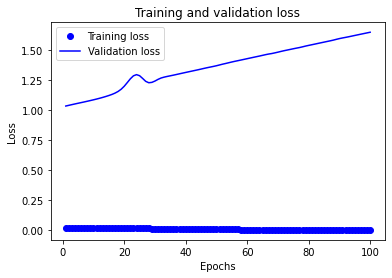

In [68]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

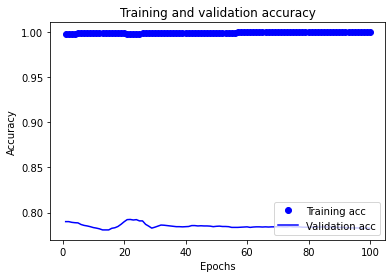

In [69]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Exporting the model for making new predictions.

Visualize the model metrics in TensorBoard.

```
%tensorboard --logdir logs
```

In [46]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 36334), started 0:23:53 ago. (Use '!kill 36334' to kill it.)

![embeddings_classifier_accuracy.png](images/embeddings_classifier_accuracy.png)

## Retrieve the trained word embeddings and save them to disk

Next, retrieve the word embeddings learned during training. The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape `(vocab_size, embedding_dimension)`.

In [41]:
vocab = vectorize_layer.get_vocabulary()
print(vocab[:10])
# Get weights matrix of layer named 'embedding'
weights = model.get_layer('embedding').get_weights()[0]
print(weights.shape) 

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
(10000, 16)


Write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), you will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [42]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(vocab):
    if num == 0: 
        continue # skip padding token from vocab
    vec = weights[num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

## Visualize the embeddings

To visualize the embeddings, upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files you created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: Experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

Note: Typically, a much larger dataset is needed to train more interpretable word embeddings. This tutorial uses a small IMDb dataset for the purpose of demonstration.


## Next Steps

This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn more about word embeddings and their mathematical representations, refer to this Stanford [note](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf).

* To learn more about advanced text processing, read the [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer).